# Building Energy Efficiency Prediction: Modeling Heating and Cooling Loads  
### Second Notebook: Objective

Following the exploratory analysis conducted in the first notebook, this second section focuses on preparing the dataset for machine learning and developing predictive models for heating load (Y1) and cooling load (Y2). The goal is to transform the insights gained from the initial EDA into a structured and reproducible modeling workflow.

More specifically, this notebook performs the necessary preprocessing steps—such as feature scaling, encoding of categorical variables, and train–test splitting—before evaluating a range of regression algorithms. These include linear and regularized models, decision trees, and multi-layer perceptrons for multi-output prediction. In addition to comparing model performance using appropriate metrics, the analysis examines feature importance and assesses the robustness of each modeling approach.

Because the dataset is simulation-based and reflects conditions specific to a warm–temperate Mediterranean climate, careful interpretation is required. The modeling process therefore not only aims to identify the most accurate algorithms, but also to understand how geometric building characteristics contribute to energy loads within this climatic context.

This notebook thus bridges the gap between descriptive insights and predictive analytics, setting the foundation for evaluating the strengths, limitations, and practical implications of data-driven energy efficiency modeling.

**Author:** J-F Jutras  
**Date:** October 2025  
**Dataset:** *Energy Efficiency Dataset – UCI Machine Learning Repository*  
**Citation:** Tsanas, A., & Xifara, A. (2012). *Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools.* *Energy and Buildings, 49*, 560–567. [DOI: 10.1016/j.enbuild.2012.03.003](https://doi.org/10.1016/j.enbuild.2012.03.003)

## 2.1-Data Loading

In [97]:
import pandas as pd

#Load the Excel file
df = pd.read_excel("/kaggle/input/energy-efficiency-dataset/ENB2012_data.xlsx")

#Display the first few rows
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


## 2.2-Data Preparation

Before training predictive models, it is essential to prepare the dataset carefully to ensure reliable and unbiased results. This section outlines the strategy used to transform and organize the data for regression analysis, considering both linear and non-linear models.

Key points of the data preparation strategy:

**Train/Test Split First:** To prevent data leakage, the dataset will be split into training and test sets before any preprocessing. This ensures that transformations are fitted only on the training data.

**Numerical Features:** For linear and regularized linear models (Linear Regression, Ridge, Lasso), numerical features will be standardized using `StandardScaler`. Standardization improves model convergence and ensures that regularization treats all features fairly. Tree-based models (Decision Trees, Random Forests, Gradient Boosting) are insensitive to scaling and do not require it.

**Categorical Features:** Categorical variables (Orientation and Glazing Area Distribution) will be encoded using one-hot encoding to allow all models to interpret these features correctly.

**Targets:** Heating load (Y1) and cooling load (Y2) will be used as-is. Although their distributions are not perfectly normal, this does not affect predictive modeling.

**Pipeline and Reproducibility:** Preprocessing steps are implemented in pipelines to ensure consistency and reproducibility across different models.

This approach provides a solid foundation for training and evaluating multiple regression models while minimizing bias and preserving data integrity.


In [98]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Suppress warnings for clean output
import warnings
warnings.filterwarnings("ignore") 

#Define features and target
#Separate features (X) and targets (y) before any transformation to avoid data leakage
X = df.drop(['Y1', 'Y2'], axis = 1)
y = df[['Y1', 'Y2']]

#Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Identify numerical and categorical features
#Numerical features will be scaled for linear models to ensure comparability and better convergence
#Categorical features will be one-hot encoded to be interpretable by all models
num_features = ['X1','X2','X3','X4','X5','X7']
cat_features = ['X6','X8']

In [99]:
#Create preprocessing pipelines
num_transformer = StandardScaler()

#Categorical pipeline with drop = 'first' to avoid multicollinearity for linear regression
cat_transformer = OneHotEncoder(drop = 'first', sparse = False)

#Combine numerical and categorical pipelines into a single preprocessor
preprocessor = ColumnTransformer(
    transformers = [
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

#Fit the preprocessor on the training data
preprocessor.fit(X_train)

#Transform the training data
X_train_processed = preprocessor.transform(X_train)

#Transform the test data
X_test_processed = preprocessor.transform (X_test)

#Reconstruct column names for transformed data
num_columns = num_features
cat_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
processed_columns = np.concatenate([num_columns, cat_columns])

#Convert NumPy arrays to DataFrames
X_train_df = pd.DataFrame(X_train_processed, columns=processed_columns, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=processed_columns, index=X_test.index)

#Quick check
X_train_df.head()

,X1,X2,X3,X4,X5,X7,X6_3,X6_4,X6_5,X8_1,X8_2,X8_3,X8_4,X8_5
60,0.553671,-0.696222,-0.007372,-0.679048,1.016421,-1.010300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
618,-1.155118,1.250664,0.558439,0.957063,-0.983844,1.227790,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
346,0.933402,-0.974349,-0.573184,-0.679048,1.016421,0.108745,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
294,1.313133,-1.252476,-0.007372,-1.224418,1.016421,0.108745,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
231,-0.965252,0.972537,-0.007372,0.957063,-0.983844,-1.010300,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## 2.3-Linear Regression Models (Ridge, Lasso and Elastic Net)

In [100]:
from sklearn.linear_model import LinearRegression

#Initialize the model: we start with a classical linear regression without regularization
lr_model = LinearRegression()

#Fit the model on the preprocessed training data
lr_model.fit(X_train_df, y_train)

#Check the model coefficients
coef_df = pd.DataFrame(
    lr_model.coef_,
    columns=X_train_df.columns,
    index=y_train.columns
)
coef_df

,X1,X2,X3,X4,X5,X7,X6_3,X6_4,X6_5,X8_1,X8_2,X8_3,X8_4,X8_5
Y1,-6.578541,-3.635389,0.770523,-3.935606,7.229054,2.309223,-0.104264,-0.047046,-0.212205,4.122271,4.232837,4.113125,3.765820,4.062491
Y2,-7.479367,-4.111477,0.129297,-4.093350,7.128415,1.812111,-0.586043,-0.318336,0.040865,1.732569,1.829138,1.657102,1.572806,1.429922


At this stage, we examine the coefficients from the linear regression to get an initial sense of which features are positively or negatively associated with the targets (Y1 and Y2). However, because several features are highly correlated, the coefficients may be unstable or misleading. To address this, we calculate the Variance Inflation Factor (VIF), which quantifies multicollinearity and helps identify features that could distort the regression results. This step ensures a more reliable interpretation of the model and informs whether any variables should be reconsidered before proceeding.

In [101]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Add a constant column to the features so that the Variance Inflation Factor (VIF) calculations 
#include an intercept term. This ensures that each feature's multicollinearity is measured 
#accurately without forcing the regression through the origin, which could distort the VIF values.
X_train_const = sm.add_constant(X_train_df)


#Calculate VIF for each feature
vif_data = pd.DataFrame({
    'Feature': X_train_const.columns,
    'VIF': [variance_inflation_factor(X_train_const.values, i)
            for i in range(X_train_const.shape[1])]
})

vif_data

,Feature,VIF
0,const,22.196440
1,X1,103.180645
2,X2,inf
3,X3,inf
4,X4,inf
5,X5,31.388002
6,X7,1.283180
7,X6_3,1.547697
8,X6_4,1.540715
9,X6_5,1.538006


In [102]:
#At this stage, we acknowledge that several numerical features (X1 to X5) are highly correlated.
#Using classical OLS regression in this situation can produce unstable and misleading coefficients.
#We will move directly to regularized regression models (Ridge and Lasso), which: 
#-Handle multicollinearity automatically 
#-Stabilize coefficients 
#-Preserve all features, maintaining interpretability for prediction 

#Ridge applies L2 regularization, shrinking coefficients toward zero to stabilize predictions.
#Lasso applies L1 regularization, which can shrink some coefficients exactly to zero, 
#effectively performing feature selection.
#Elastic Net combines L1 and L2 penalties, allowing both coefficient shrinkage (stabilization)
#and variable selection, which can be especially useful when predictors are highly correlated.

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score

#Custom RMSE scorer for GridSearchCV
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_sklearn = make_scorer(rmse_scorer, greater_is_better=False)

#KFold CV setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Ridge Regression with hyperparameter tuning
ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10, 50, 100]}

ridge_base = Ridge()
ridge_grid = GridSearchCV(ridge_base, ridge_param_grid, scoring = rmse_sklearn, cv = cv, n_jobs = -1)
ridge_multi = MultiOutputRegressor(ridge_grid)
ridge_multi.fit(X_train_df, y_train)

y_pred_ridge = ridge_multi.predict(X_test_df)
print("Ridge Regression (Optimized CV):")
print("Best alpha:", ridge_multi.estimators_[0].best_params_['alpha'])
print("R2 score:", r2_score(y_test, y_pred_ridge))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

#Lasso Regression with hyperparameter tuning
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10]}

lasso_base = Lasso(max_iter = 5000)
lasso_grid = GridSearchCV(lasso_base, lasso_param_grid, scoring = rmse_sklearn, cv = cv, n_jobs = -1)
lasso_multi = MultiOutputRegressor(lasso_grid)
lasso_multi.fit(X_train_df, y_train)

y_pred_lasso = lasso_multi.predict(X_test_df)
print("\nLasso Regression (Optimized CV):")
print("Best alpha:", lasso_multi.estimators_[0].best_params_['alpha'])
print("R2 score:", r2_score(y_test, y_pred_lasso))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

#Elastic Net Regression with hyperparameter tuning
en_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9]
}

en_base = ElasticNet(max_iter = 5000)
en_grid = GridSearchCV(en_base, en_param_grid, scoring = rmse_sklearn, cv = cv, n_jobs = -1)
en_multi = MultiOutputRegressor(en_grid)
en_multi.fit(X_train_df, y_train)

y_pred_en = en_multi.predict(X_test_df)
print("\nElastic Net Regression (Optimized CV):")
print("Best params:", en_multi.estimators_[0].best_params_)
print("R2 score:", r2_score(y_test, y_pred_en))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_en)))

Ridge Regression (Optimized CV):
Best alpha: 0.1
R2 score: 0.9077945869181554
RMSE: 3.00041164399597

Lasso Regression (Optimized CV):
Best alpha: 0.001
R2 score: 0.9077467744566844
RMSE: 3.001172159878807

Elastic Net Regression (Optimized CV):
Best params: {'alpha': 0.001, 'l1_ratio': 0.7}
R2 score: 0.907551413928938
RMSE: 3.0044047062112966


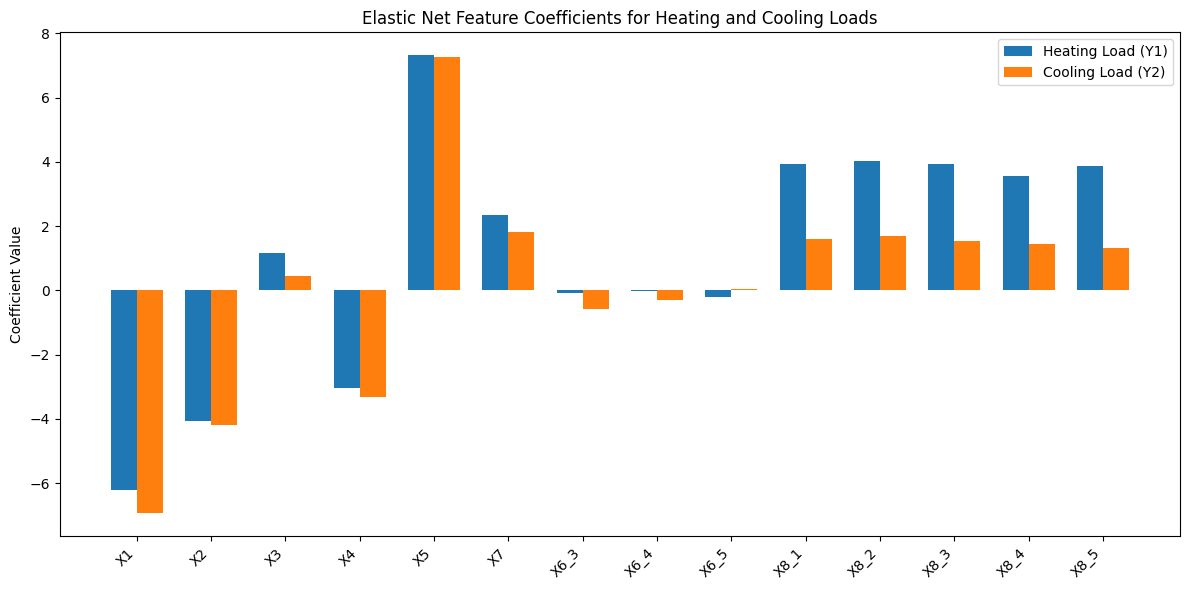

In [103]:
#Here we use Elastic Net because it combines L1 (Lasso) and L2 (Ridge) penalties. This allows this model
#to handle multicollinearity (common in our numerical features X1-X5),stabilize coefficients, and perform
#feature selection by shrinking some coefficients to zero. We choose a bar plot of coefficients because
#linear models give both the direction (sign) and strength (magnitude) of each feature's influence on the
#target. This allows us to interpret which building characteristics increase or decrease energy load.

#Retrieve coefficients for both targets
coef_y1 = en_multi.estimators_[0].best_estimator_.coef_
coef_y2 = en_multi.estimators_[1].best_estimator_.coef_

x = np.arange(len(X_train_df.columns))
width = 0.35 

plt.figure(figsize = (12,6))
plt.bar(x - width/2, coef_y1, width, label='Heating Load (Y1)')
plt.bar(x + width/2, coef_y2, width, label='Cooling Load (Y2)')
plt.xticks(x, X_train_df.columns, rotation = 45, ha = 'right')
plt.ylabel('Coefficient Value')
plt.title('Elastic Net Feature Coefficients for Heating and Cooling Loads')
plt.legend()
plt.tight_layout()
plt.show()


Using Elastic Net, we can clearly see both the direction and strength of each feature’s influence on the targets (Heating Load Y1 and Cooling Load Y2). Features X5, X1, and X2 are the most impactful for both targets. Specifically, X5 (e.g., overall wall area) has a strong positive effect, meaning increases in this feature raise energy loads. In contrast, X1 (e.g., relative compactness) and X2 (surface area) have strong negative coefficients, indicating that larger or more compact buildings reduce loads. Other features like X8_2, X8_1, and X8_3 also contribute positively, but to a lesser extent. Smaller coefficients near zero (e.g., X6_3, X6_4) suggest minimal impact. Importantly, the magnitude of the coefficients is similar for Y1 and Y2 for the top features, showing that some building characteristics consistently influence both heating and cooling demands. 

Elastic Net is particularly useful here because it handles multicollinearity among correlated features (X1–X5) while still providing interpretable coefficients, allowing us to make concrete recommendations about which building parameters most strongly affect energy performance.

## 2.4-Tree-Based Regression Models

In [104]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#Define a scorer compatible with GridSearchCV
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_sklearn = make_scorer(rmse_scorer, greater_is_better=False)

#KFold cross-validation setup
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Decision Tree with GridSearch
dt_param_grid = {
    'estimator__max_depth': [None, 5, 10, 15],
    'estimator__min_samples_split': [2, 5, 10],
    'estimator__min_samples_leaf': [1, 2, 4]
}

dt_base = MultiOutputRegressor(DecisionTreeRegressor(random_state = 42))
dt_grid = GridSearchCV(dt_base, dt_param_grid, scoring = rmse_sklearn, cv = cv, n_jobs = -1)
dt_grid.fit(X_train_df, y_train)

y_pred_dt = dt_grid.predict(X_test_df)
print("Decision Tree Regression (Optimized CV):")
print("Best params:", dt_grid.best_params_)
print("R2 score:", r2_score(y_test, y_pred_dt))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))

#Random Forest with GridSearch
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_base = RandomForestRegressor(random_state = 42)
rf_grid = GridSearchCV(rf_base, rf_param_grid, scoring = rmse_sklearn, cv = cv, n_jobs = -1)
rf_grid.fit(X_train_df, y_train)

y_pred_rf = rf_grid.predict(X_test_df)
print("\nRandom Forest Regression (Optimized CV):")
print("Best params:", rf_grid.best_params_)
print("R2 score:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

#Gradient Boosting with GridSearch (wrapped in MultiOutputRegressor)
gb_param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7]
}

gb_base = MultiOutputRegressor(GradientBoostingRegressor(random_state = 42))
gb_grid = GridSearchCV(gb_base, gb_param_grid, scoring = rmse_sklearn, cv = cv, n_jobs = -1)
gb_grid.fit(X_train_df, y_train)

y_pred_gb = gb_grid.predict(X_test_df)
print("\nGradient Boosting Regression (Optimized CV):")
print("Best params:", gb_grid.best_params_)
print("R2 score:", r2_score(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))

Decision Tree Regression (Optimized CV):
Best params: {'estimator__max_depth': None, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 10}
R2 score: 0.9769006324872597
RMSE: 1.470458074173815

Random Forest Regression (Optimized CV):
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
R2 score: 0.9779341294340023
RMSE: 1.436228349471327

Gradient Boosting Regression (Optimized CV):
Best params: {'estimator__learning_rate': 0.2, 'estimator__max_depth': 5, 'estimator__n_estimators': 300}
R2 score: 0.994545457454565
RMSE: 0.7155360203834845


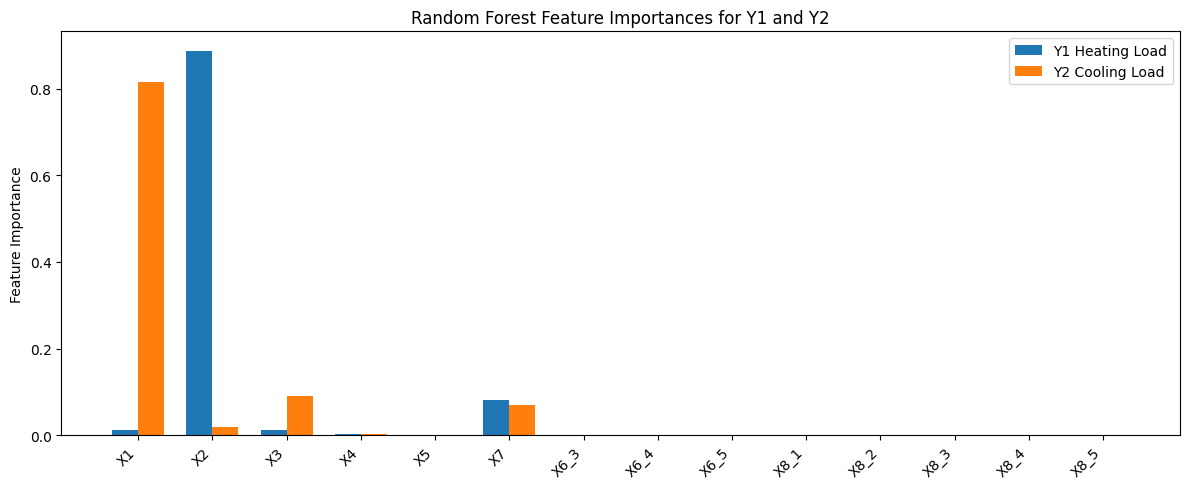

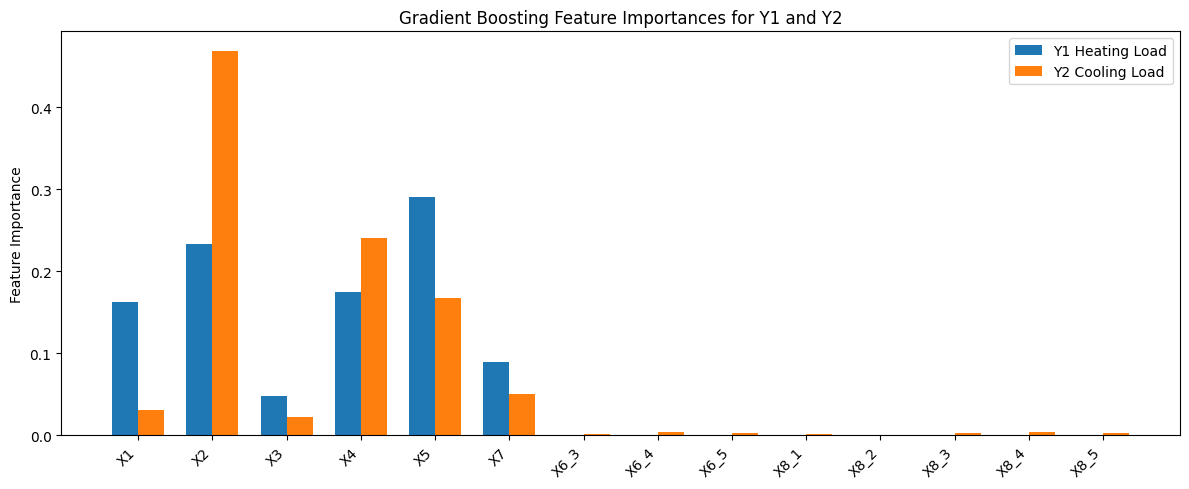

In [105]:
#Tree-based models naturally handle multicollinearity and non-linear interactions. We use feature
#importance plots because they directly quantify the contribution of each feature to reducing prediction
#error, giving insight into which building characteristics most influence energy loads. Unlike linear
#models, the direction of effect (positive/negative) is not explicit, but the magnitude tells us the
#relative importance of each feature.

#Random Forest Feature Importances for Y1 and Y2
rf_y1_importances = rf_grid.best_estimator_.estimators_[0].feature_importances_
rf_y2_importances = rf_grid.best_estimator_.estimators_[1].feature_importances_
features = X_train_df.columns
x = np.arange(len(features))
width = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - width/2, rf_y1_importances, width, label='Y1 Heating Load')
plt.bar(x + width/2, rf_y2_importances, width, label='Y2 Cooling Load')
plt.xticks(x, features, rotation=45, ha='right')
plt.ylabel('Feature Importance')
plt.title('Random Forest Feature Importances for Y1 and Y2')
plt.legend()
plt.tight_layout()
plt.show()

#Gradient Boosting Feature Importances for Y1 and Y2
gb_y1_importances = gb_grid.best_estimator_.estimators_[0].feature_importances_
gb_y2_importances = gb_grid.best_estimator_.estimators_[1].feature_importances_

plt.figure(figsize=(12,5))
plt.bar(x - width/2, gb_y1_importances, width, label='Y1 Heating Load')
plt.bar(x + width/2, gb_y2_importances, width, label='Y2 Cooling Load')
plt.xticks(x, features, rotation=45, ha='right')
plt.ylabel('Feature Importance')
plt.title('Gradient Boosting Feature Importances for Y1 and Y2')
plt.legend()
plt.tight_layout()
plt.show()

For Random Forest, X1 (compactness) dominates cooling load (Y2), while X2 (surface area) is the most important for heating load (Y1). Gradient Boosting, on the other hand, shifts importance differently: for Y1, X5 and X2 are top contributors, whereas for Y2, X2 and X4 are most important. This occurs because Random Forest averages over many trees, capturing the strongest predictors per target but generally producing similar global patterns. Gradient Boosting sequentially optimizes predictions and can pick up more subtle, target-specific non-linear interactions. In interpretation, RF highlights the dominant global drivers of energy loads, while GB helps understand nuanced, target-specific influences.

## 2.5-Neural Network Model

In [106]:
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning 
import warnings

#Define RMSE scorer
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_sklearn = make_scorer(rmse_scorer, greater_is_better=False)

#KFold CV
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#MLPRegressor with GridSearchCV
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],          
    'learning_rate_init': [0.001, 0.01]
}

mlp_base = MLPRegressor(max_iter = 5000, random_state = 42)

mlp_grid = GridSearchCV(
    mlp_base,
    mlp_param_grid,
    scoring = rmse_sklearn,
    cv = cv,
    n_jobs = -1,
    verbose = 1
)

#Fit inside warning catch block
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    mlp_grid.fit(X_train_df, y_train)

#Predictions
y_pred_mlp = mlp_grid.predict(X_test_df)

#Evaluation
print("MLP Regression (Optimized CV):")
print("Best params:", mlp_grid.best_params_)
print("R2 score:", r2_score(y_test, y_pred_mlp))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mlp)))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
MLP Regression (Optimized CV):
Best params: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.001}
R2 score: 0.9831171706465869
RMSE: 1.2593560760900884


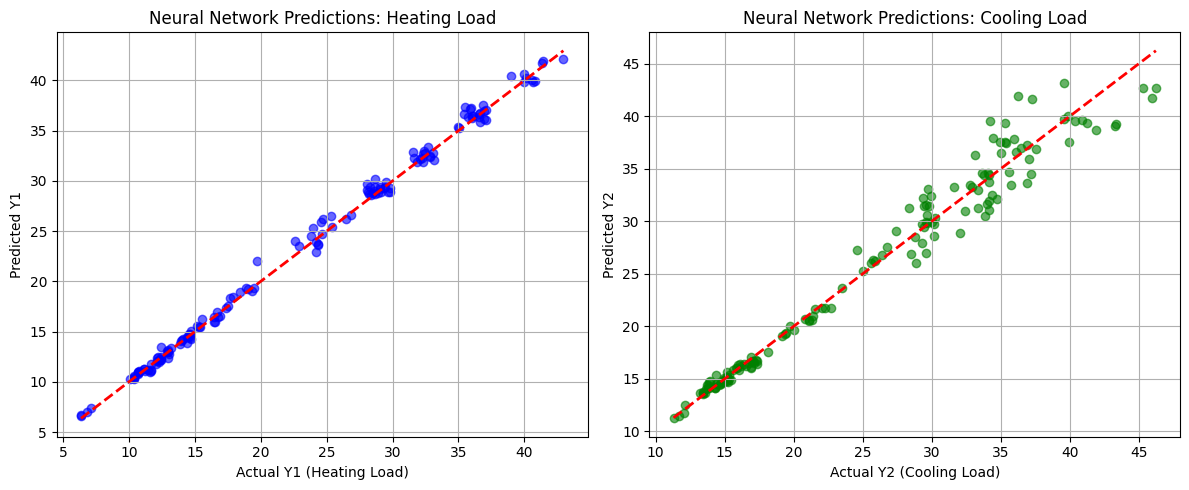

In [107]:
#Here we use a scatter plot of predicted vs actual values for each target. This is particularly useful
#for neural networks, where feature importance is not directly available. 
#It shows overall model performance and potential bias.

plt.figure(figsize=(12,5))

#Heating Load (Y1)
plt.subplot(1,2,1)
plt.scatter(y_test['Y1'], y_pred_mlp[:,0], alpha = 0.6, color = 'blue')
plt.plot([y_test['Y1'].min(), y_test['Y1'].max()],
         [y_test['Y1'].min(), y_test['Y1'].max()],
         color = 'red', linestyle = '--', linewidth = 2)
plt.xlabel('Actual Y1 (Heating Load)')
plt.ylabel('Predicted Y1')
plt.title('Neural Network Predictions: Heating Load')
plt.grid(True)

#Cooling Load (Y2)
plt.subplot(1,2,2)
plt.scatter(y_test['Y2'], y_pred_mlp[:,1], alpha = 0.6, color = 'green')
plt.plot([y_test['Y2'].min(), y_test['Y2'].max()],
         [y_test['Y2'].min(), y_test['Y2'].max()],
         color = 'red', linestyle = '--', linewidth = 2)
plt.xlabel('Actual Y2 (Cooling Load)')
plt.ylabel('Predicted Y2')
plt.title('Neural Network Predictions: Cooling Load')
plt.grid(True)

plt.tight_layout()
plt.show()

For the Neural Network (MLP) model, we focus on predicted versus actual values and residuals for both heating (Y1) and cooling (Y2) loads. The predicted vs actual scatter plots indicate that the model closely follows the 45-degree line, demonstrating strong predictive performance. Residual plots help us check for systematic errors: small, randomly scattered residuals around zero suggest that the MLP captures the underlying non-linear relationships in the data without obvious bias. Compared to linear models, the MLP excels at modeling complex interactions among features, though it does not provide interpretable coefficients. Thus, while we gain predictive accuracy, feature-level interpretability must rely on complementary models such as Elastic Net or tree-based methods.

In [109]:
#List of models and their predictions
models = ['Ridge', 'Lasso', 'Elastic Net', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network']
predictions = [y_pred_ridge, y_pred_lasso, y_pred_en, y_pred_dt, y_pred_rf, y_pred_gb, y_pred_mlp]

#Calculate R2 and RMSE for each model
results = []
for model, y_pred in zip(models, predictions):
    #R2 score for model
    r2_val = r2_score(y_test, y_pred)
    #RMSE for model
    rmse_val = (mean_squared_error(y_test, y_pred))**0.5
    results.append({'Model': model, 'R2': r2_val, 'RMSE': rmse_val})

#Create summary DataFrame
summary_df = pd.DataFrame(results)

#Sort by R2 descending (best models first)
summary_df = summary_df.sort_values(by='R2', ascending=False).reset_index(drop=True)

#Display summary
summary_df

,Model,R2,RMSE
0,Gradient Boosting,0.994545,0.715536
1,Neural Network,0.983117,1.259356
2,Random Forest,0.977934,1.436228
3,Decision Tree,0.976901,1.470458
4,Ridge,0.907795,3.000412
5,Lasso,0.907747,3.001172
6,Elastic Net,0.907551,3.004405


## 2.6-Summary

**Data Preparation**
- Dataset split into training and test sets to prevent data leakage.
- Numerical features (`X1`, `X2`, `X3`, `X4`, `X5`, `X7`) standardized for better convergence and comparability.
- Categorical features (`X6` – Orientation, `X8` – Glazing Area Distribution) one-hot encoded, first category dropped to avoid multicollinearity.
- Preprocessing implemented with `ColumnTransformer` pipelines for reproducibility and consistent transformations.
- Prepared dataset suitable for both linear and non-linear regression models, ensuring unbiased evaluation and interpretable feature contributions.

**Linear Regression and Regularized Models**
- **Ridge, Lasso, and Elastic Net** applied to handle multicollinearity among numerical features (X1–X5) and stabilize coefficients.
- Predictive performance was **very similar** across all three models (R² ~0.91, RMSE ~3) due to high correlations among predictors:
  - L1 (Lasso) and L2 (Ridge) penalties distribute weights similarly when features are highly correlated.
  - Elastic Net combines both penalties, balancing shrinkage and sparsity; in this dataset, it behaves similarly to Ridge.
- **Elastic Net** chosen for visualization because it provides both **direction (positive/negative)** and **magnitude**, enabling clear interpretation.
- Key coefficient insights:
  - **X5 (wall area)** increases both heating (Y1) and cooling load (Y2).
  - **X1 (relative compactness)** and **X2 (surface area)** decrease energy loads.
  - Secondary features like X3, X6 series, and X8 series have smaller effects.
    
**Tree-Based Models (Random Forest and Gradient Boosting)**
- Tree-based models handle multicollinearity and non-linear interactions naturally.
- Feature importance plots quantify each feature’s contribution to reducing prediction error.
- Observations:
  - **Random Forest:** Y1 (heating load) most influenced by X2 (surface area) and X5 (wall area); Y2 (cooling load) most influenced by X1 (relative compactness) and X4 (roof area).  
  - **Gradient Boosting:** Y1 influenced mainly by X5 and X2; Y2 influenced mainly by X2 and X4.
- Differences in importance arise because Random Forest averages many decorrelated trees (more robust, smoother importance), while Gradient Boosting sequentially reduces residuals (can highlight features with strong gradient contributions).
- Interpretation: magnitudes reflect relative importance; direction (positive/negative) not explicit, unlike linear models.

**Neural Network (MLPRegressor)**
- Neural networks capture complex non-linear relationships that linear and tree models may miss.
- Predicted vs Actual plots and residual distributions show strong overall performance (R² ~0.98 for Y1/Y2; RMSE ~1.26).
- Residuals centered near zero with relatively small variance, indicating unbiased predictions and low systematic error.

**Limitations**
- High multicollinearity among numerical features required regularized models; linear coefficients may still be sensitive to correlated predictors.
- Interpretability of complex models (Gradient Boosting, Neural Networks) is limited: feature importance gives magnitude but not direction, and MLP provides no direct feature-level insights.
- Multi-output regression assumes that heating and cooling loads are predicted jointly but does not model potential conditional dependencies between them explicitly.
